In [1]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np
import pandas as pd

import os
import sys

sys.path.append(os.path.abspath(os.path.join("../..", "emotions")))
from emotions import emotions_labels
from utils import predict_one, load_similarity_matrix, plot_confusion

c:\Users\Lucio\Documents\entornos\env3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
RESULTS_STORAGE_PATH = "sentiment_results"
CSV_PROMPTRS_PATH = "eval_prompts.csv"
IDX = {lbl: i for i, lbl in enumerate(emotions_labels)}

## Hard evaluation

                                                text       label        pred
0  Your dedication to volunteering is truly inspi...  admiration  admiration
1  That joke about the cat wearing a tie made me ...   amusement   amusement
2  I can't believe you deleted all my work withou...       anger    surprise
3  That drill noise at seven in the morning again...   annoyance   annoyance
4      Great job, that refactor turned out flawless.    approval  admiration
Hard accuracy : 0.685


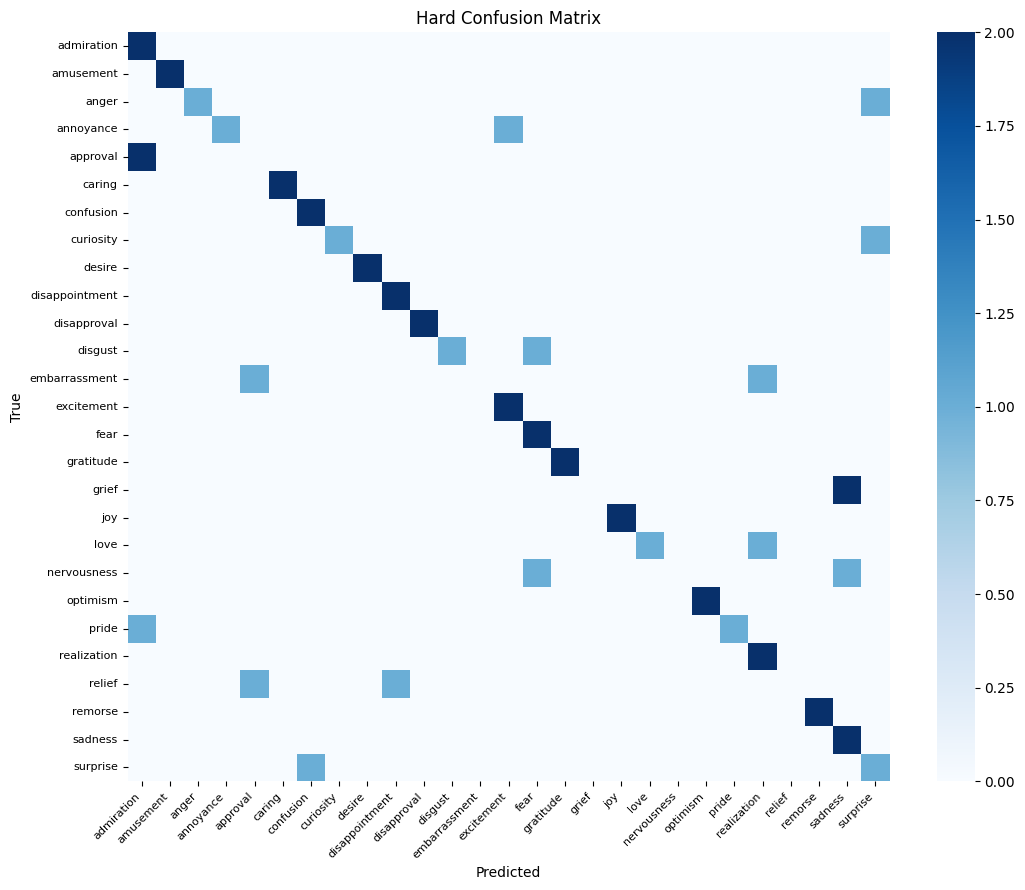

In [3]:
df = pd.read_csv(CSV_PROMPTRS_PATH)
df["pred"] = df["text"].apply(predict_one)
print(df.head())
y_true = df["label"].values
y_pred = df["pred"].values
hard_acc = accuracy_score(y_true, y_pred)
hard_cm  = confusion_matrix(y_true, y_pred, labels=emotions_labels)

print(f"Hard accuracy : {hard_acc:.3f}")
plot_confusion(hard_cm, emotions_labels,
                title="Hard Confusion Matrix",
                fname=os.path.join(RESULTS_STORAGE_PATH, "cm_hard.png"),
                vmax=hard_cm.max())

In [4]:
report = classification_report(df["label"], df["pred"], digits=3, zero_division=0)
report_path = os.path.join(RESULTS_STORAGE_PATH, "classification_report.txt")
with open(report_path, "w") as f:
    f.write(report)
print(f"Classification report saved to {report_path}")
print("report:")
print(report)

Classification report saved to sentiment_results\classification_report.txt
report:
                precision    recall  f1-score   support

    admiration      0.400     1.000     0.571         2
     amusement      1.000     1.000     1.000         2
         anger      1.000     0.500     0.667         2
     annoyance      1.000     0.500     0.667         2
      approval      0.000     0.000     0.000         2
        caring      1.000     1.000     1.000         2
     confusion      0.667     1.000     0.800         2
     curiosity      1.000     0.500     0.667         2
        desire      1.000     1.000     1.000         2
disappointment      0.667     1.000     0.800         2
   disapproval      1.000     1.000     1.000         2
       disgust      1.000     0.500     0.667         2
 embarrassment      0.000     0.000     0.000         2
    excitement      0.667     1.000     0.800         2
          fear      0.500     1.000     0.667         2
     gratitude      

## Soft evaluation

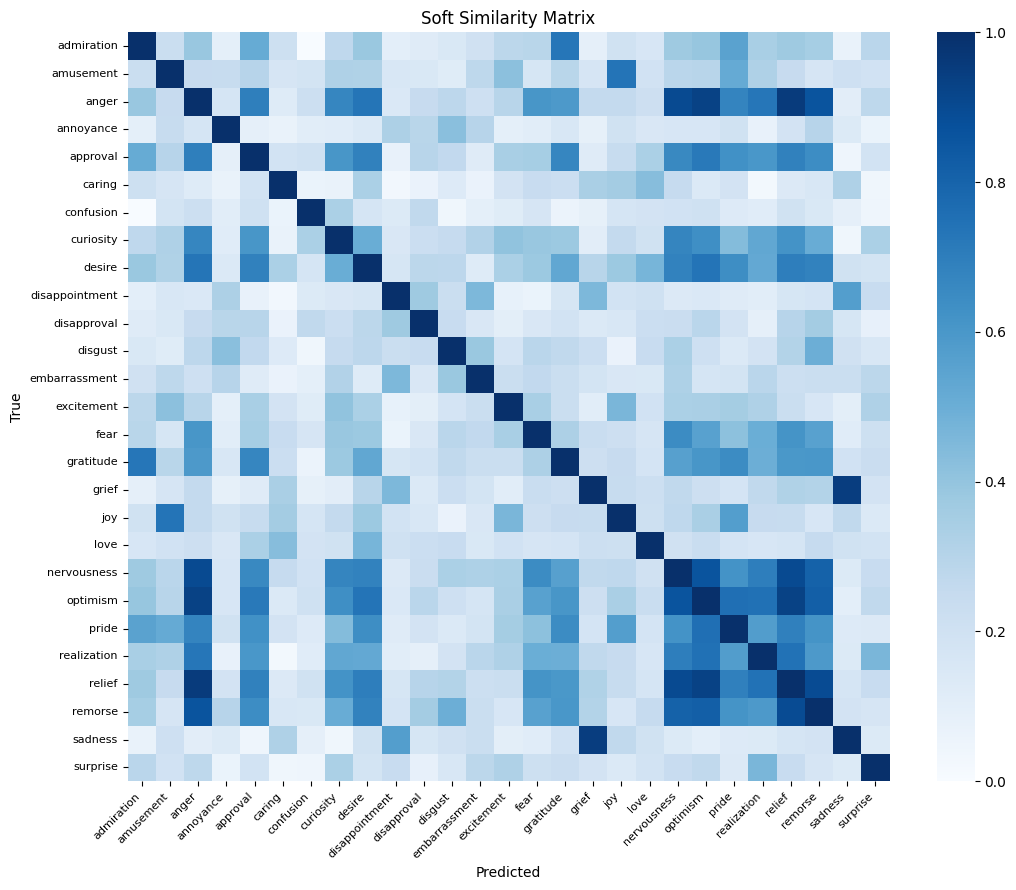

Soft accuracy : 0.810


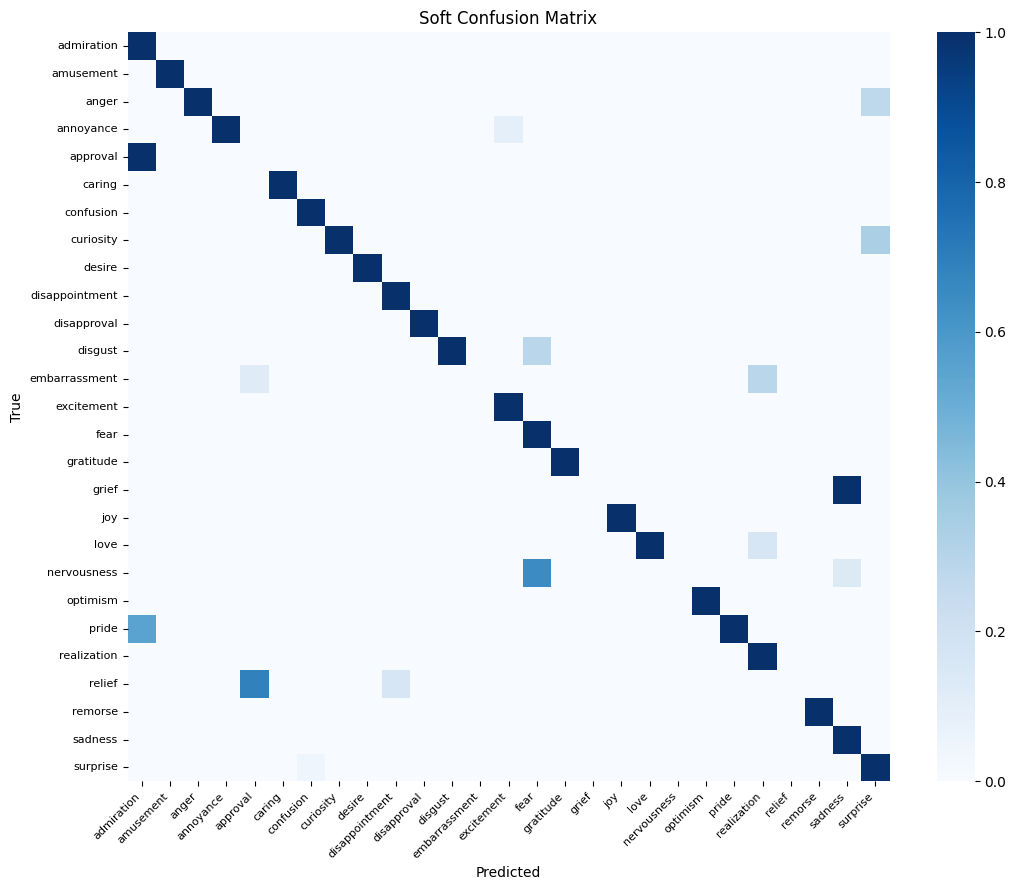

In [5]:
S = load_similarity_matrix()
plot_confusion(S, emotions_labels,
                title="Soft Similarity Matrix",
                fname=os.path.join(RESULTS_STORAGE_PATH, "cm_soft_similarity.png"),
                vmax=S.max(), save=False)

soft_scores = [S[IDX[t], IDX[p]] for t, p in zip(y_true, y_pred)]
soft_acc    = np.mean(soft_scores)
print(f"Soft accuracy : {soft_acc:.3f}")
soft_cm = np.zeros_like(S)
for t, p in zip(y_true, y_pred):
    soft_cm[IDX[t], IDX[p]] += S[IDX[t], IDX[p]]

plot_confusion(soft_cm, emotions_labels,
                title="Soft Confusion Matrix",
                fname=os.path.join(RESULTS_STORAGE_PATH, "cm_soft.png"), vmax=1.0)

df.to_csv(os.path.join(RESULTS_STORAGE_PATH, "eval_prompts_with_preds.csv"), index=False)